In [1]:
import os
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Set your local root directory here
root_dir = r"C:\Users\Administrator\Desktop\New folder (7)"

# labeled_data folder path (before fine-tuning)
labeled_data_dir = os.path.join(root_dir, "labeled_data")

# data folder path (after fine-tuning)
data_dir = os.path.join(root_dir, "data")


In [2]:
from PIL import Image
import os

def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return img.format.lower() in ['jpg', 'jpeg', 'png', 'bmp']
    except:
        return False

# Update this path to your labeled_data folder
data_base_dir = r"C:\Users\Administrator\Desktop\New folder (7)\labeled_data"

subdirs = ['train', 'valid']  # No 'test' folder

for subdir in subdirs:
    data_dir = os.path.join(data_base_dir, subdir)
    if not os.path.exists(data_dir):
        print(f'Directory {data_dir} does not exist')
        continue
    for image_class in os.listdir(data_dir):
        class_path = os.path.join(data_dir, image_class)
        if not os.path.isdir(class_path):
            continue
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                if not is_valid_image(image_path):
                    print(f'Invalid image format: {image_path}')
                    os.remove(image_path)
            except Exception as e:
                print(f'Issue with image {image_path}: {e}')


In [3]:
train_folder = r"C:\Users\Administrator\Desktop\New folder (7)\labeled_data\train"
validate_folder = r"C:\Users\Administrator\Desktop\New folder (7)\labeled_data\valid"

class_names = ['benign', 'malignant', 'normal']


In [4]:
# Set your local folders here
train_folder = r"C:\Users\Administrator\Desktop\New folder (7)\labeled_data\train"
validate_folder = r"C:\Users\Administrator\Desktop\New folder (7)\labeled_data\valid"

# 256 x 256
train = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
)

validate = tf.keras.utils.image_dataset_from_directory(
    validate_folder,
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
)

# 224 x 224
train1 = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,
)

validate1 = tf.keras.utils.image_dataset_from_directory(
    validate_folder,
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,
)
# 244 x 244
train2 = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',
    image_size=(244, 244),
    batch_size=32,

)

validate2 = tf.keras.utils.image_dataset_from_directory(
    validate_folder,
    label_mode='categorical',
    image_size=(244, 244),
    batch_size=32,

)


Found 6346 files belonging to 3 classes.
Found 1713 files belonging to 3 classes.
Found 6346 files belonging to 3 classes.
Found 1713 files belonging to 3 classes.
Found 6346 files belonging to 3 classes.
Found 1713 files belonging to 3 classes.


Batch classes: [0 0 0 0 2 0 2 0 0 0 0 0 0 1 0 2 2 0 0 0 0 0 0 0 0 0 0 1 0 0 1 2]


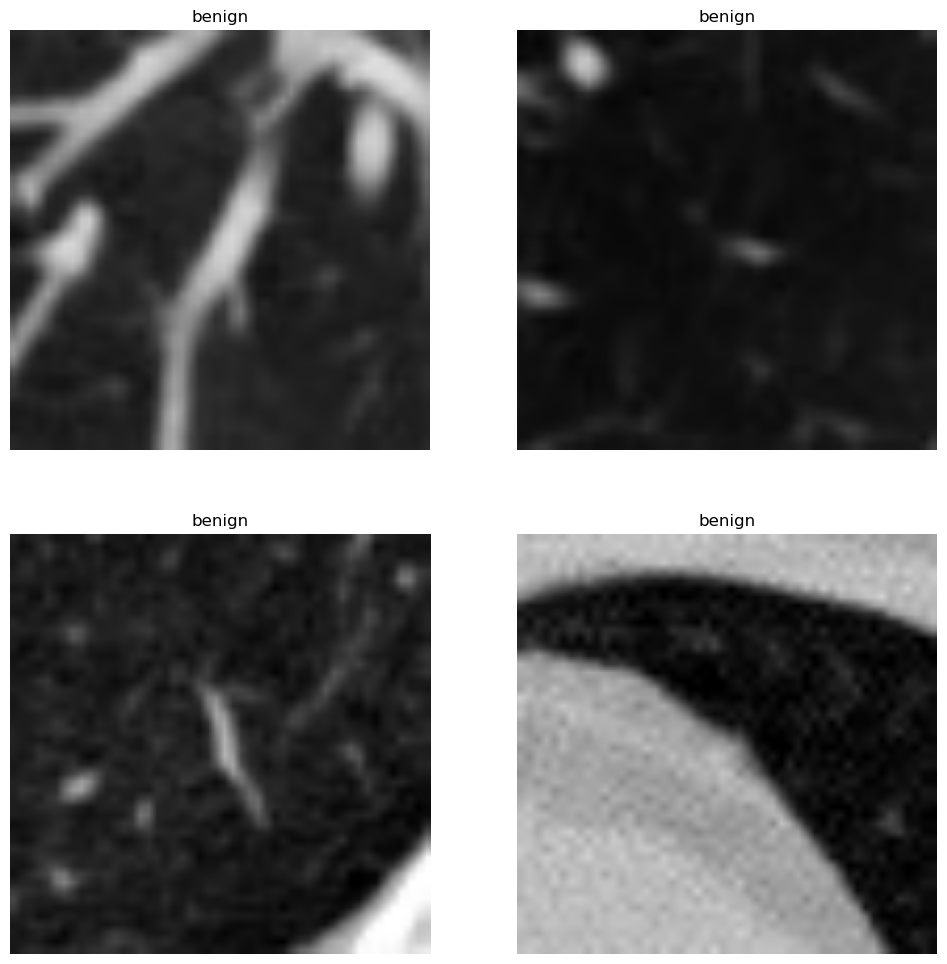

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# Take one batch from the train dataset
for images, labels in train.take(1):
    print('Batch classes:', tf.argmax(labels, axis=1).numpy())  # Print class indices of batch
    
    for i in range(4):  # Show first 4 images
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')

plt.show()


In [6]:
from tensorflow.keras import regularizers
import tensorflow as tf
import datetime

IMG_SHAPE = (244, 244, 3)

# Define your custom CNN as base_model
base_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (8, 8), strides=(3, 3), activation='relu', input_shape=IMG_SHAPE),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3)),

    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten()
])

base_model.trainable = True  # since it's your own model

# Now use it in the same way as before
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1, input_shape=IMG_SHAPE),
    base_model,
    tf.keras.layers.Dense(
        1024,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.025)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(
        3,  # Changed from 2 to 3 for 'benign', 'malignant', 'normal'
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.01)
    )
])


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [8]:
import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import os

os.makedirs('logs/fit', exist_ok=True)

# Updated to reflect your custom CNN
log_dir = f'logs/fit/customcnn_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [9]:
history = model.fit(
    train2,
    validation_data=validate2,
    epochs=50,
    callbacks=[tensorboard_callback, early_stopping]
)


Epoch 1/50



KeyboardInterrupt



In [119]:
model.save("my_custom_cnn.h5")


In [10]:
from PIL import Image
import os

# === Function to check if image is valid ===
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verifies but doesn't load image into memory
        return img.format.lower() in ['jpg', 'jpeg', 'png', 'bmp']
    except:
        return False

# === Base dataset directory (corrected path) ===
data_base_dir = r'C:\Users\Administrator\Desktop\New folder (7)\data'

# === Subdirectories to clean ===
subdirs = ['train', 'valid', 'test']  # Don't add any folder path here

# === Loop through all class folders and remove invalid images ===
for subdir in subdirs:
    data_dir = os.path.join(data_base_dir, subdir)
    if not os.path.exists(data_dir):
        print(f'Directory {data_dir} does not exist')
        continue
    for image_class in os.listdir(data_dir):
        class_path = os.path.join(data_dir, image_class)
        if not os.path.isdir(class_path):
            continue
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                if not is_valid_image(image_path):
                    print(f'❌ Invalid image format: {image_path}')
                    os.remove(image_path)
            except Exception as e:
                print(f'⚠️ Issue with image {image_path}: {e}')

# === Example cleaned folder paths ===
train_folder = r'C:\Users\Administrator\Desktop\New folder (7)\data\train'
validate_folder = r'C:\Users\Administrator\Desktop\New folder (7)\data\valid'

# === Class names ===
class_names = ['benign', 'malignant', 'normal']


Found 14037 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 723 files belonging to 3 classes.
Model loaded.
Epoch 1/50
439/439 - 56s - loss: 0.5111 - accuracy: 0.8269 - val_loss: 0.1319 - val_accuracy: 0.9883 - 56s/epoch - 128ms/step
Epoch 2/50
439/439 - 52s - loss: 0.2197 - accuracy: 0.9462 - val_loss: 0.1577 - val_accuracy: 0.9750 - 52s/epoch - 118ms/step
Epoch 3/50
439/439 - 52s - loss: 0.1343 - accuracy: 0.9815 - val_loss: 0.0874 - val_accuracy: 0.9967 - 52s/epoch - 118ms/step
Epoch 4/50
439/439 - 51s - loss: 0.0938 - accuracy: 0.9949 - val_loss: 0.0804 - val_accuracy: 0.9983 - 51s/epoch - 117ms/step
Epoch 5/50
439/439 - 51s - loss: 0.0823 - accuracy: 0.9963 - val_loss: 0.1470 - val_accuracy: 0.9700 - 51s/epoch - 116ms/step
Epoch 6/50
439/439 - 52s - loss: 0.0735 - accuracy: 0.9979 - val_loss: 0.0648 - val_accuracy: 0.9967 - 52s/epoch - 119ms/step
Epoch 7/50
439/439 - 52s - loss: 0.0626 - accuracy: 0.9994 - val_loss: 0.0593 - val_accuracy: 0.9983 - 52s/e

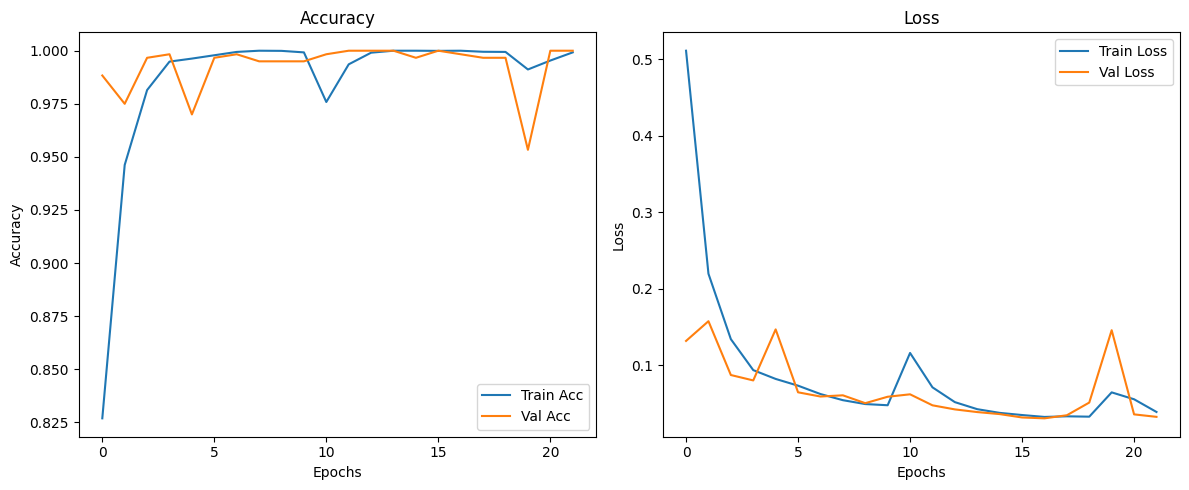

23/23 - 2s - loss: 0.1394 - accuracy: 0.9571 - 2s/epoch - 74ms/step
Test Loss: 0.1394
Test Accuracy: 0.9571
1/1 [==============================] - 0s 224ms/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.66      1.00      0.79        60
   malignant       1.00      0.93      0.96       455
      normal       1.00      1.00      1.00       208

    accuracy                           0.96       723
   macro avg       0.89      0.98      0.92       723
weighted avg       0.97      0.96      0.96       723

F1 Score (macro): 0.9198
Recall (macro): 0.9773


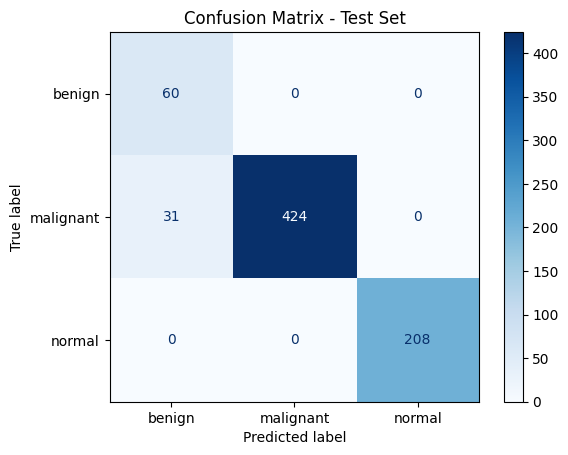

In [128]:
#finetune CNN


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import datetime

# === Dataset Preparation ===
train_dataset = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\train',
    label_mode='int',
    image_size=(244, 244),
    batch_size=32,
    shuffle=True
)

validate_dataset = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\valid',
    label_mode='int',
    image_size=(244, 244),
    batch_size=32,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\test',
    label_mode='int',
    image_size=(244, 244),
    batch_size=32,
    shuffle=False
)

# === Load and Prepare Model ===
model = tf.keras.models.load_model('my_custom_cnn.h5')
print("Model loaded.")

# Unfreeze all layers for full fine-tuning
for layer in model.layers:
    layer.trainable = True

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Fine-Tuning ===
history_finetune = model.fit(
    train_dataset,
    validation_data=validate_dataset,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        TensorBoard(log_dir=f"logs/fine_tune_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
    ],
    verbose=2
)

# === Save Fine-Tuned Model ===
model.save('fine_tuned_my_custom_cnn.h5')
print("Model saved as 'fine_tuned_my_custom_cnn.h5'.")

# === Plot Training & Validation Loss/Accuracy ===
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history_finetune)

# === Evaluation on Test Set ===

# Evaluate test loss and accuracy directly
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Prepare lists to gather true and predicted labels
y_true = []
y_pred = []

class_names = test_dataset.class_names

# Predict batch-wise on the test dataset
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report with precision, recall, f1-score
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate macro-averaged F1 and recall
f1 = f1_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")
print(f"Recall (macro): {recall:.4f}")

# Confusion Matrix and Plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [132]:
#@title MobileNet Model
import datetime
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
base_model_mobilenet = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_mobilenet.trainable = False

model_mobilenet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(
        1024,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(
        3,
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.01)
    )
])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

log_dir_mobilenet = f'logs/fit/mobilenet_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback_mobilenet = tf.keras.callbacks.TensorBoard(log_dir=log_dir_mobilenet, histogram_freq=1)

history_mobilenet = model_mobilenet.fit(
    train1,
    validation_data=validate1,
    epochs=50,
    callbacks=[tensorboard_callback_mobilenet, early_stopping]
)

model_mobilenet.save("mobilenet_model.h5")

Epoch 1/50
199/199 [==============================] - 17s 66ms/step - loss: 9.1185 - accuracy: 0.8771 - val_loss: 6.6838 - val_accuracy: 0.9078
Epoch 2/50
199/199 [==============================] - 12s 60ms/step - loss: 5.2026 - accuracy: 0.9061 - val_loss: 3.9958 - val_accuracy: 0.9083
Epoch 3/50
199/199 [==============================] - 12s 60ms/step - loss: 3.2335 - accuracy: 0.9177 - val_loss: 2.6326 - val_accuracy: 0.9142
Epoch 4/50
199/199 [==============================] - 12s 61ms/step - loss: 2.2152 - accuracy: 0.9212 - val_loss: 1.8877 - val_accuracy: 0.9229
Epoch 5/50
199/199 [==============================] - 12s 60ms/step - loss: 1.6395 - accuracy: 0.9236 - val_loss: 1.4534 - val_accuracy: 0.9194
Epoch 6/50
199/199 [==============================] - 12s 61ms/step - loss: 1.2802 - accuracy: 0.9307 - val_loss: 1.1957 - val_accuracy: 0.9072
Epoch 7/50
199/199 [==============================] - 12s 60ms/step - loss: 1.0357 - accuracy: 0.9343 - val_loss: 1.0093 - val_accuracy:

In [11]:
import tensorflow as tf

train_dataset2 = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\train',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

validate_dataset2 = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\valid',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

test_dataset2 = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\test',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 14037 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 723 files belonging to 3 classes.


MobileNet model loaded.
Epoch 1/50
439/439 - 45s - loss: 0.4751 - accuracy: 0.8398 - val_loss: 1.3832 - val_accuracy: 0.5317 - 45s/epoch - 102ms/step
Epoch 2/50
439/439 - 38s - loss: 0.2595 - accuracy: 0.9335 - val_loss: 0.8109 - val_accuracy: 0.7183 - 38s/epoch - 86ms/step
Epoch 3/50
439/439 - 38s - loss: 0.1992 - accuracy: 0.9597 - val_loss: 0.4675 - val_accuracy: 0.8567 - 38s/epoch - 86ms/step
Epoch 4/50
439/439 - 38s - loss: 0.1577 - accuracy: 0.9773 - val_loss: 0.2940 - val_accuracy: 0.9183 - 38s/epoch - 86ms/step
Epoch 5/50
439/439 - 38s - loss: 0.1334 - accuracy: 0.9850 - val_loss: 0.2410 - val_accuracy: 0.9350 - 38s/epoch - 86ms/step
Epoch 6/50
439/439 - 38s - loss: 0.1172 - accuracy: 0.9897 - val_loss: 0.1800 - val_accuracy: 0.9567 - 38s/epoch - 86ms/step
Epoch 7/50
439/439 - 38s - loss: 0.1020 - accuracy: 0.9939 - val_loss: 0.1816 - val_accuracy: 0.9517 - 38s/epoch - 86ms/step
Epoch 8/50
439/439 - 38s - loss: 0.0944 - accuracy: 0.9947 - val_loss: 0.1345 - val_accuracy: 0.9817

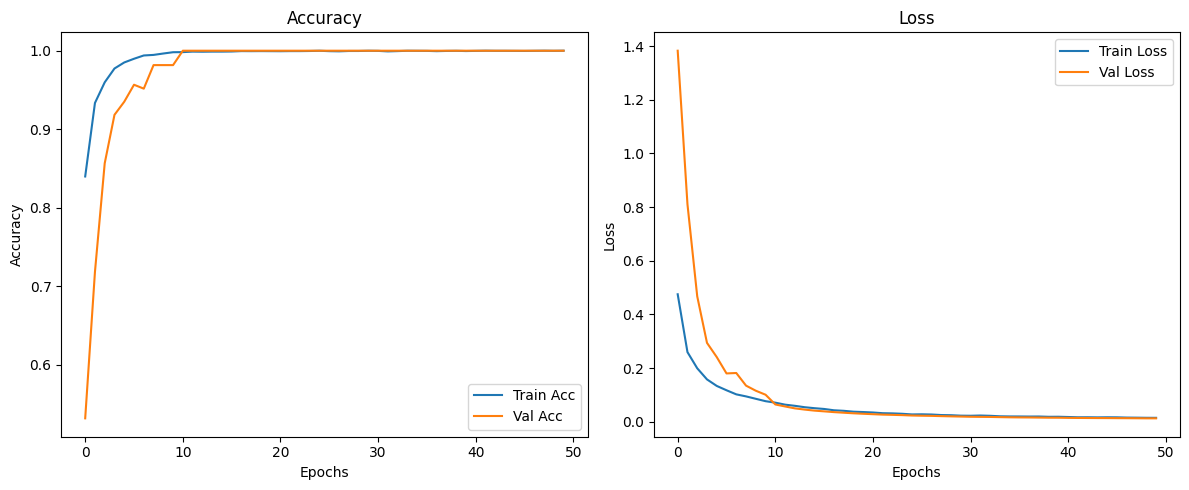

1/1 [==============================] - 1s 821ms/step

F1 Score (weighted): 1.0000
Recall (weighted): 1.0000


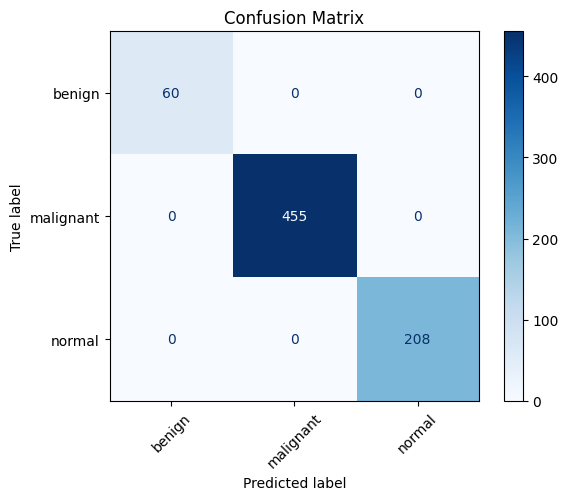

In [134]:
# === FINE-TUNING FULL MOBILENET V2 ===
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score

# === Assume train_dataset2, validate_dataset2, test_dataset2 are already defined ===
# === Also, class_names should be defined like this: ===
class_names = test_dataset2.class_names

# === Load and prepare model ===
model_mobilenet = tf.keras.models.load_model('mobilenet_model.h5')
print("MobileNet model loaded.")

# === Unfreeze all layers for full fine-tuning ===
for layer in model_mobilenet.layers:
    layer.trainable = True

# Compile the model
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Fine-tune model ===
history = model_mobilenet.fit(
    train_dataset2,
    validation_data=validate_dataset2,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=f"logs/mobilenet_full_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
    ],
    verbose=2
)

# === Save fine-tuned model ===
model_mobilenet.save('fine_tuned_mobilenet_model.h5')
print("Fine-tuned MobileNet model saved.")

# === Evaluate on test data ===
test_loss, test_acc = model_mobilenet.evaluate(test_dataset2, verbose=2)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# === Plot accuracy and loss ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# === F1 Score, Recall, Confusion Matrix ===
y_true = []
y_pred = []

for images, labels in test_dataset2:
    preds = model_mobilenet.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"\nF1 Score (weighted): {f1:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()



In [13]:
#@title Xception Model
import tensorflow as tf
from tensorflow.keras import regularizers 
from tensorflow.keras.callbacks import EarlyStopping

base_model_xception = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model_xception.trainable = False

model_xception = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    base_model_xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(
        1024,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.015)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(
        3,
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.015)
    )
])

model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [9]:
import datetime
log_dir_xception = f'logs/fit/xception_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback_xception = tf.keras.callbacks.TensorBoard(log_dir=log_dir_xception, histogram_freq=1)

history_xception = model_xception.fit(
    train,
    validation_data=validate,
    epochs=50,
    callbacks=[tensorboard_callback_xception, early_stopping]
)

model_xception.save("xception_model.h5")

Epoch 1/50
199/199 [==============================] - 25s 89ms/step - loss: 12.9653 - accuracy: 0.8735 - val_loss: 6.9685 - val_accuracy: 0.8961
Epoch 2/50
199/199 [==============================] - 16s 82ms/step - loss: 4.2554 - accuracy: 0.8938 - val_loss: 2.3723 - val_accuracy: 0.9113
Epoch 3/50
199/199 [==============================] - 16s 81ms/step - loss: 1.5925 - accuracy: 0.9028 - val_loss: 1.0443 - val_accuracy: 0.9124
Epoch 4/50
199/199 [==============================] - 16s 81ms/step - loss: 0.8192 - accuracy: 0.9061 - val_loss: 0.6422 - val_accuracy: 0.9142
Epoch 5/50
199/199 [==============================] - 16s 81ms/step - loss: 0.5697 - accuracy: 0.9058 - val_loss: 0.5026 - val_accuracy: 0.9159
Epoch 6/50
199/199 [==============================] - 16s 82ms/step - loss: 0.4684 - accuracy: 0.9072 - val_loss: 0.4236 - val_accuracy: 0.9101
Epoch 7/50
199/199 [==============================] - 16s 81ms/step - loss: 0.4171 - accuracy: 0.9080 - val_loss: 0.4171 - val_accuracy

In [10]:
# === Xception: Dataset Loading (Train, Validation, Test) ===
import tensorflow as tf

# Train dataset
train_dataset1 = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\train',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

# Validation dataset
validate_dataset1 = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\valid',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False
)

# Test dataset
test_dataset1 = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\Administrator\Desktop\New folder (7)\data\test',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False
)


Found 14037 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 723 files belonging to 3 classes.


Xception model loaded.
Epoch 1/5
439/439 - 28s - loss: 1.4463 - accuracy: 0.3790 - val_loss: 0.9549 - val_accuracy: 0.6433 - 28s/epoch - 64ms/step
Epoch 2/5
439/439 - 25s - loss: 1.0576 - accuracy: 0.5036 - val_loss: 0.9334 - val_accuracy: 0.6833 - 25s/epoch - 56ms/step
Epoch 3/5
439/439 - 24s - loss: 1.0235 - accuracy: 0.5367 - val_loss: 0.9154 - val_accuracy: 0.7050 - 24s/epoch - 54ms/step
Epoch 4/5
439/439 - 24s - loss: 1.0046 - accuracy: 0.5599 - val_loss: 0.9060 - val_accuracy: 0.7233 - 24s/epoch - 55ms/step
Epoch 5/5
439/439 - 24s - loss: 0.9945 - accuracy: 0.5683 - val_loss: 0.9124 - val_accuracy: 0.6950 - 24s/epoch - 54ms/step
Epoch 1/50
439/439 - 88s - loss: 0.5998 - accuracy: 0.7995 - val_loss: 0.3838 - val_accuracy: 0.8867 - 88s/epoch - 201ms/step
Epoch 2/50
439/439 - 82s - loss: 0.2520 - accuracy: 0.9477 - val_loss: 0.1178 - val_accuracy: 0.9983 - 82s/epoch - 186ms/step
Epoch 3/50
439/439 - 82s - loss: 0.1674 - accuracy: 0.9783 - val_loss: 0.0942 - val_accuracy: 1.0000 - 82

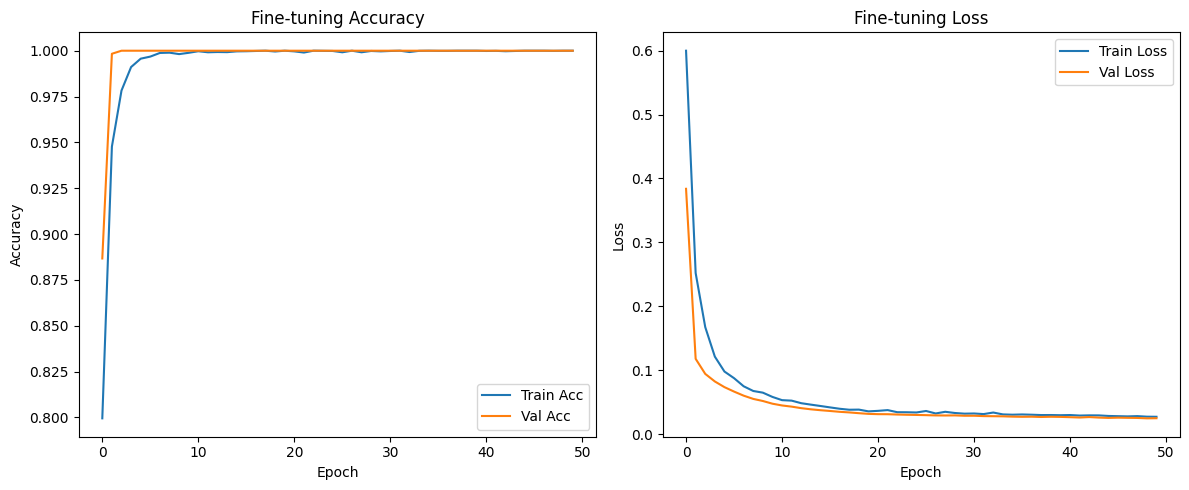

1/1 [==============================] - 1s 1s/step

F1 Score: 1.0000
Recall: 1.0000


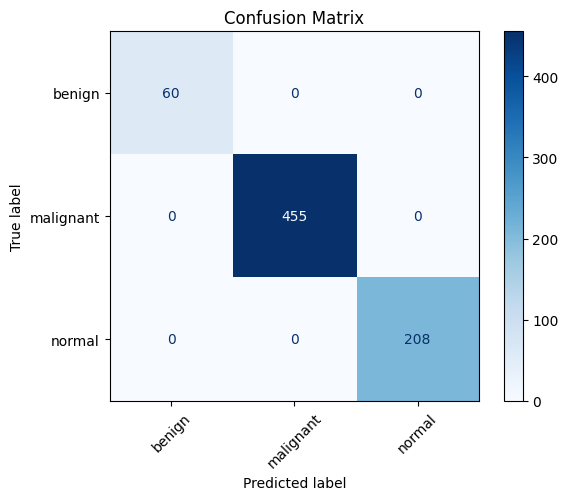

In [11]:
# === Fine-tune Xception model ===
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Load the saved Xception model
model_xception = tf.keras.models.load_model('xception_model.h5')
print("Xception model loaded.")

# Freeze all layers except the last 2
for layer in model_xception.layers[:-2]:
    layer.trainable = False
for layer in model_xception.layers[-2:]:
    layer.trainable = True

# Compile for head training
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # using int labels
    metrics=['accuracy']
)

# Head training
history_xception_head = model_xception.fit(
    train_dataset1,
    validation_data=validate_dataset1,
    epochs=5,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        TensorBoard(log_dir=f"logs/xception_head_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
    ],
    verbose=2
)

# === Full model fine-tuning ===

# Unfreeze all layers
for layer in model_xception.layers:
    layer.trainable = True

# Re-compile for fine-tuning
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_xception_finetune = model_xception.fit(
    train_dataset1,
    validation_data=validate_dataset1,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        TensorBoard(log_dir=f"logs/xception_fine_tune_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
    ],
    verbose=2
)

# Save the fine-tuned model
model_xception.save('fine_tuned_xception_model.h5')
print("Fine-tuned Xception model saved.")

# === Evaluation on test set ===

test_loss, test_acc = model_xception.evaluate(test_dataset1, verbose=2)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# === Plot accuracy and loss from fine-tuning ===

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_xception_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_xception_finetune.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_xception_finetune.history['loss'], label='Train Loss')
plt.plot(history_xception_finetune.history['val_loss'], label='Val Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# === F1 Score, Recall, Confusion Matrix ===

y_true = []
y_pred = []

for images, labels in test_dataset1:
    preds = model_xception.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"\nF1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset1.class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Invalid image skipped: C:\Users\ensi02\hedii\data\test\benign\.ipynb_checkpoints
Invalid image skipped: C:\Users\ensi02\hedii\data\test\malignant\.ipynb_checkpoints

=== Fold 1 ===
Fine-tuning full model...
Epoch 1/30
351/351 - 75s - loss: 0.4901 - accuracy: 0.8532 - val_loss: 0.7408 - val_accuracy: 0.7100 - 75s/epoch - 214ms/step
Epoch 2/30
351/351 - 69s - loss: 0.2180 - accuracy: 0.9586 - val_loss: 0.4490 - val_accuracy: 0.8683 - 69s/epoch - 196ms/step
Epoch 3/30
351/351 - 69s - loss: 0.1525 - accuracy: 0.9836 - val_loss: 0.7430 - val_accuracy: 0.6933 - 69s/epoch - 197ms/step
Epoch 4/30
351/351 - 70s - loss: 0.1186 - accuracy: 0.9929 - val_loss: 1.3473 - val_accuracy: 0.4567 - 70s/epoch - 200ms/step
Epoch 5/30
351/351 - 70s - loss: 0.1036 - accuracy: 0.9955 - val_loss: 0.5474 - val_accuracy: 0.7817 - 70s/epoch - 199ms/step
Epoch 6/30
351/351 - 70s - loss: 0.0903 - accuracy: 0.9976 - val_loss: 0.3775 - val_accuracy: 0.8483 - 70s/epoch - 200ms/step
Epoch 7/30
351/351 - 71s - loss: 0.08

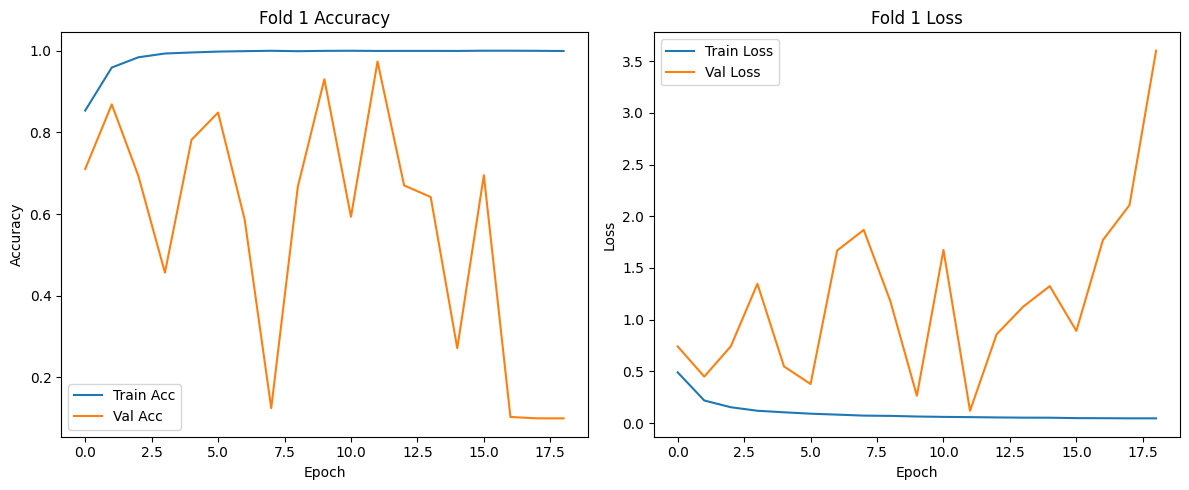

1/1 [==============================] - 1s 772ms/step
Fold 1 Validation Recall: 0.9744
Fold 1 Validation F1 Score: 0.9475


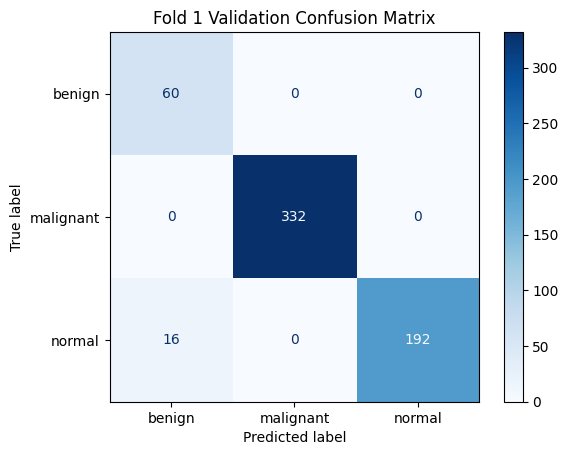

23/23 - 1s - loss: 0.0995 - accuracy: 0.9834 - 832ms/epoch - 36ms/step
Fold 1 Test accuracy: 0.9834 | Test loss: 0.0995
1/1 [==============================] - 0s 30ms/step
Fold 1 Test Recall: 0.9808
Fold 1 Test F1 Score: 0.9637


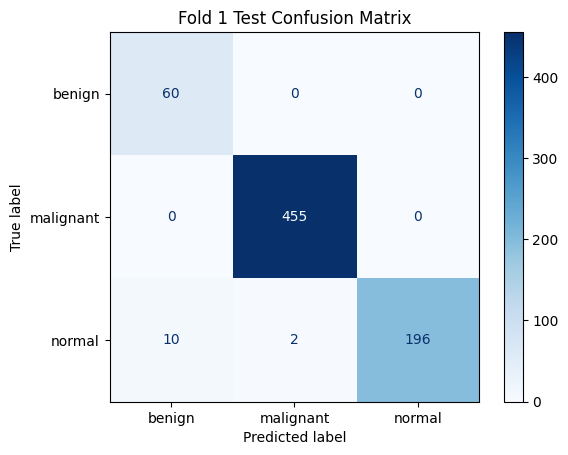


=== Fold 2 ===
Fine-tuning full model...
Epoch 1/30
351/351 - 82s - loss: 0.4879 - accuracy: 0.8545 - val_loss: 0.8223 - val_accuracy: 0.6567 - 82s/epoch - 233ms/step
Epoch 2/30
351/351 - 75s - loss: 0.2208 - accuracy: 0.9576 - val_loss: 0.5335 - val_accuracy: 0.7833 - 75s/epoch - 213ms/step
Epoch 3/30
351/351 - 75s - loss: 0.1533 - accuracy: 0.9834 - val_loss: 1.1006 - val_accuracy: 0.6450 - 75s/epoch - 213ms/step
Epoch 4/30
351/351 - 75s - loss: 0.1215 - accuracy: 0.9941 - val_loss: 1.5959 - val_accuracy: 0.3233 - 75s/epoch - 213ms/step
Epoch 5/30
351/351 - 75s - loss: 0.1041 - accuracy: 0.9959 - val_loss: 0.8269 - val_accuracy: 0.6950 - 75s/epoch - 214ms/step
Epoch 6/30
351/351 - 76s - loss: 0.0909 - accuracy: 0.9980 - val_loss: 0.9690 - val_accuracy: 0.6367 - 76s/epoch - 215ms/step
Epoch 7/30
351/351 - 76s - loss: 0.0813 - accuracy: 0.9982 - val_loss: 0.3696 - val_accuracy: 0.8667 - 76s/epoch - 218ms/step
Epoch 8/30
351/351 - 78s - loss: 0.0753 - accuracy: 0.9988 - val_loss: 1.133

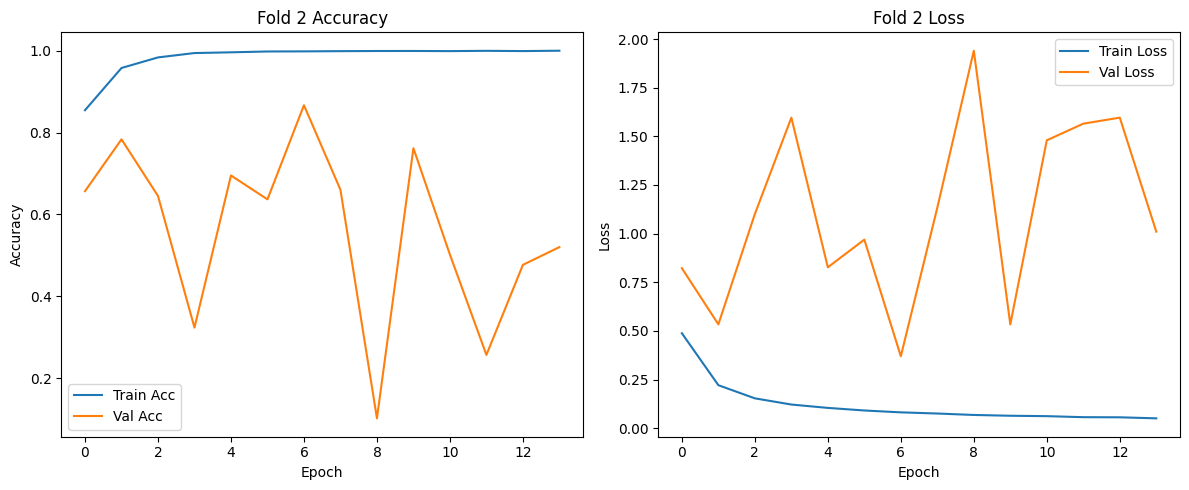

1/1 [==============================] - 1s 811ms/step
Fold 2 Validation Recall: 0.8718
Fold 2 Validation F1 Score: 0.8320


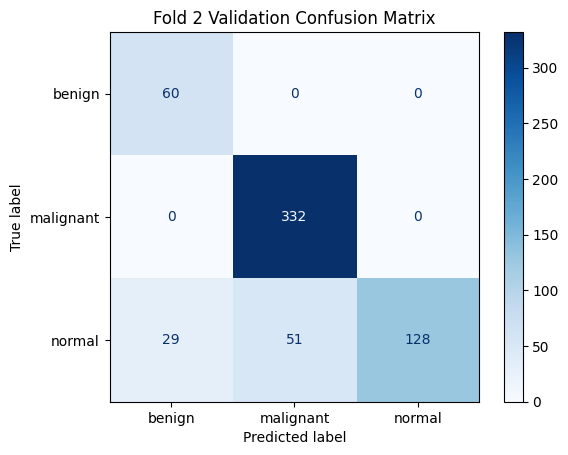

23/23 - 1s - loss: 0.3112 - accuracy: 0.8963 - 846ms/epoch - 37ms/step
Fold 2 Test accuracy: 0.8963 | Test loss: 0.3112
1/1 [==============================] - 0s 32ms/step
Fold 2 Test Recall: 0.8561
Fold 2 Test F1 Score: 0.8517


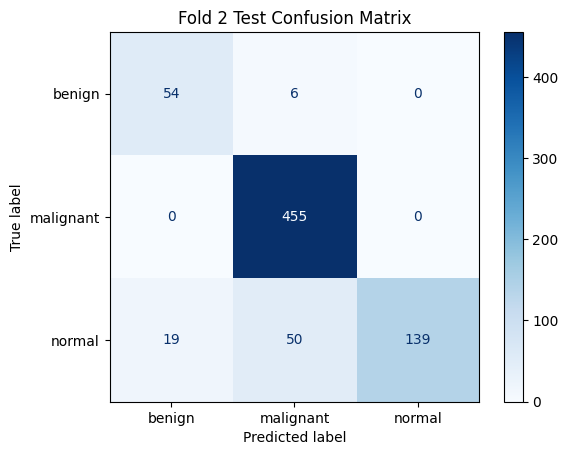


=== Fold 3 ===
Fine-tuning full model...
Epoch 1/30
351/351 - 85s - loss: 0.4906 - accuracy: 0.8567 - val_loss: 0.8327 - val_accuracy: 0.6467 - 85s/epoch - 243ms/step
Epoch 2/30
351/351 - 79s - loss: 0.2209 - accuracy: 0.9595 - val_loss: 0.2863 - val_accuracy: 0.9467 - 79s/epoch - 225ms/step
Epoch 3/30
351/351 - 80s - loss: 0.1568 - accuracy: 0.9825 - val_loss: 2.6235 - val_accuracy: 0.1000 - 80s/epoch - 227ms/step
Epoch 4/30
351/351 - 79s - loss: 0.1229 - accuracy: 0.9916 - val_loss: 1.4959 - val_accuracy: 0.4700 - 79s/epoch - 225ms/step
Epoch 5/30
351/351 - 79s - loss: 0.1037 - accuracy: 0.9958 - val_loss: 0.6882 - val_accuracy: 0.7350 - 79s/epoch - 226ms/step
Epoch 6/30
351/351 - 80s - loss: 0.0909 - accuracy: 0.9978 - val_loss: 1.7731 - val_accuracy: 0.1033 - 80s/epoch - 227ms/step
Epoch 7/30
351/351 - 80s - loss: 0.0818 - accuracy: 0.9983 - val_loss: 1.5861 - val_accuracy: 0.1650 - 80s/epoch - 227ms/step
Epoch 8/30
351/351 - 79s - loss: 0.0749 - accuracy: 0.9986 - val_loss: 0.316

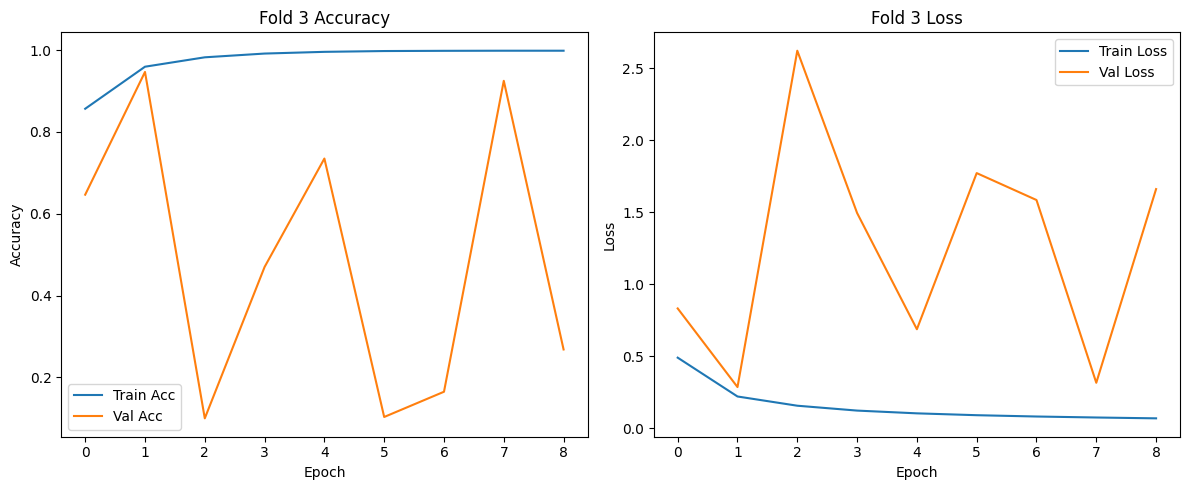

1/1 [==============================] - 1s 792ms/step
Fold 3 Validation Recall: 0.9426
Fold 3 Validation F1 Score: 0.9030


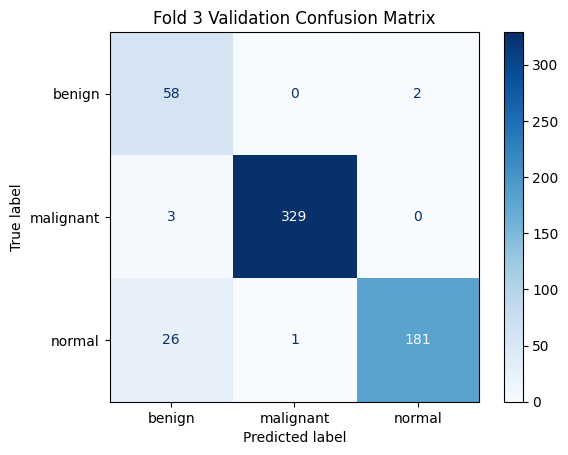

23/23 - 1s - loss: 0.2920 - accuracy: 0.9350 - 806ms/epoch - 35ms/step
Fold 3 Test accuracy: 0.9350 | Test loss: 0.2920
1/1 [==============================] - 0s 30ms/step
Fold 3 Test Recall: 0.9089
Fold 3 Test F1 Score: 0.8633


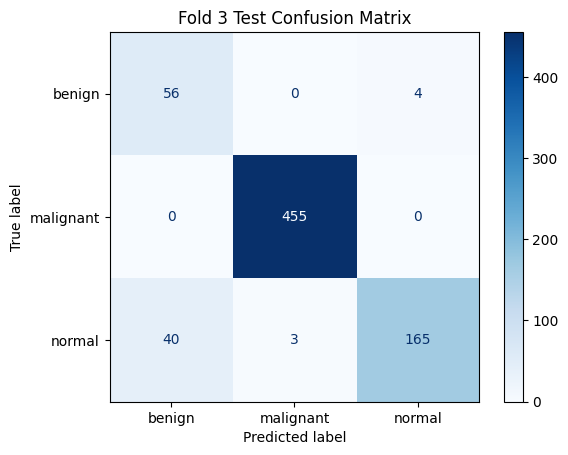


=== Fold 4 ===
Fine-tuning full model...
Epoch 1/30
351/351 - 88s - loss: 0.4891 - accuracy: 0.8532 - val_loss: 0.7610 - val_accuracy: 0.7133 - 88s/epoch - 251ms/step
Epoch 2/30
351/351 - 81s - loss: 0.2210 - accuracy: 0.9580 - val_loss: 0.5734 - val_accuracy: 0.7800 - 81s/epoch - 231ms/step
Epoch 3/30
351/351 - 81s - loss: 0.1543 - accuracy: 0.9847 - val_loss: 2.0013 - val_accuracy: 0.2067 - 81s/epoch - 231ms/step
Epoch 4/30
351/351 - 81s - loss: 0.1212 - accuracy: 0.9928 - val_loss: 0.8182 - val_accuracy: 0.6667 - 81s/epoch - 230ms/step
Epoch 5/30
351/351 - 81s - loss: 0.1013 - accuracy: 0.9970 - val_loss: 1.3463 - val_accuracy: 0.5817 - 81s/epoch - 232ms/step
Epoch 6/30
351/351 - 82s - loss: 0.0898 - accuracy: 0.9979 - val_loss: 0.8077 - val_accuracy: 0.6850 - 82s/epoch - 233ms/step
Epoch 7/30
351/351 - 82s - loss: 0.0807 - accuracy: 0.9982 - val_loss: 1.4174 - val_accuracy: 0.5183 - 82s/epoch - 233ms/step
Epoch 8/30
351/351 - 82s - loss: 0.0759 - accuracy: 0.9977 - val_loss: 1.074

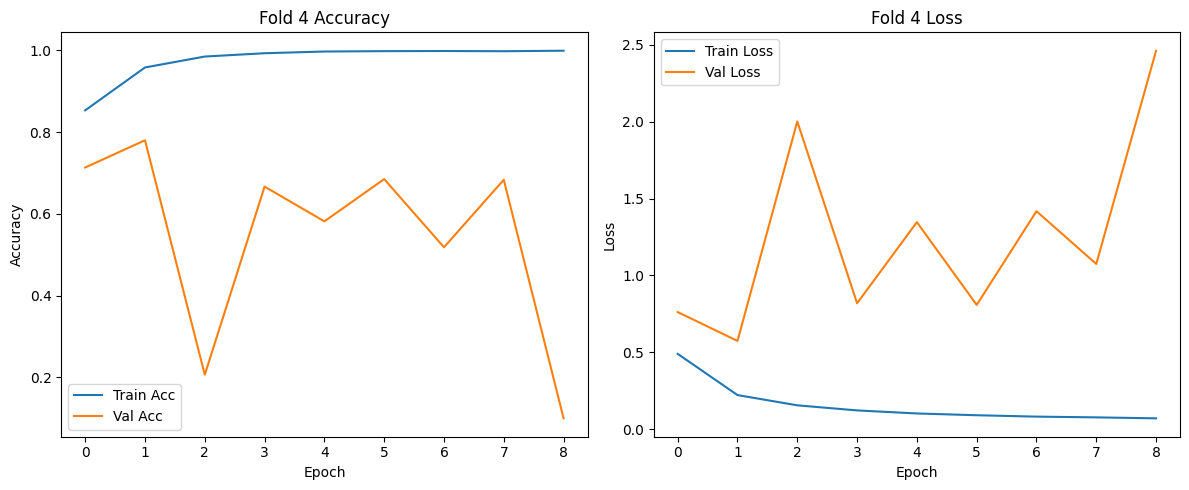

1/1 [==============================] - 1s 1s/step
Fold 4 Validation Recall: 0.7885
Fold 4 Validation F1 Score: 0.6717


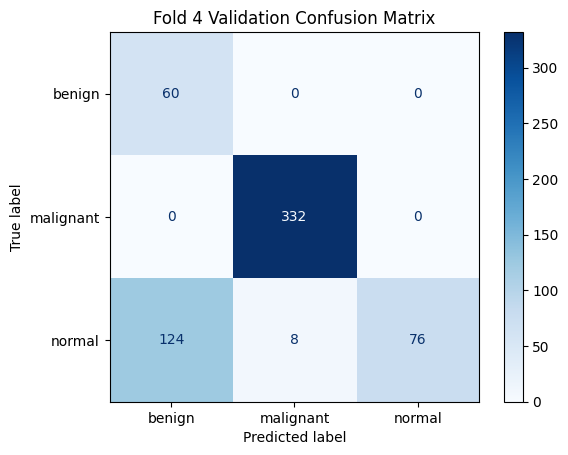

23/23 - 1s - loss: 0.5214 - accuracy: 0.8091 - 845ms/epoch - 37ms/step
Fold 4 Test accuracy: 0.8091 | Test loss: 0.5214
1/1 [==============================] - 0s 31ms/step
Fold 4 Test Recall: 0.7560
Fold 4 Test F1 Score: 0.6672


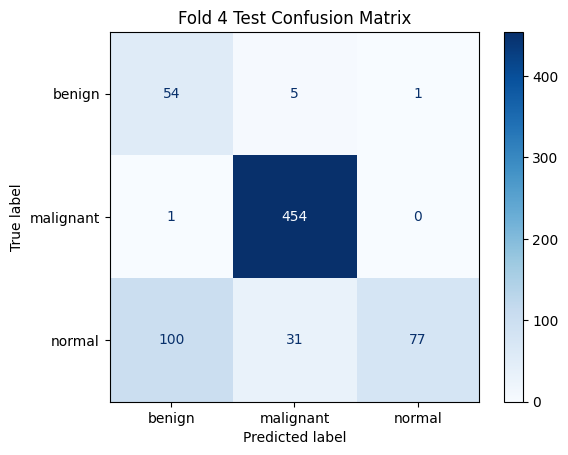


=== Fold 5 ===
Fine-tuning full model...
Epoch 1/30
351/351 - 89s - loss: 0.4855 - accuracy: 0.8601 - val_loss: 0.7408 - val_accuracy: 0.7367 - 89s/epoch - 252ms/step
Epoch 2/30
351/351 - 82s - loss: 0.2165 - accuracy: 0.9652 - val_loss: 0.7413 - val_accuracy: 0.6933 - 82s/epoch - 234ms/step
Epoch 3/30
351/351 - 83s - loss: 0.1547 - accuracy: 0.9834 - val_loss: 0.6194 - val_accuracy: 0.7933 - 83s/epoch - 237ms/step
Epoch 4/30
351/351 - 82s - loss: 0.1233 - accuracy: 0.9914 - val_loss: 1.8558 - val_accuracy: 0.2650 - 82s/epoch - 232ms/step
Epoch 5/30
351/351 - 82s - loss: 0.1018 - accuracy: 0.9965 - val_loss: 0.7914 - val_accuracy: 0.7383 - 82s/epoch - 233ms/step
Epoch 6/30
351/351 - 82s - loss: 0.0908 - accuracy: 0.9974 - val_loss: 3.1547 - val_accuracy: 0.1000 - 82s/epoch - 233ms/step
Epoch 7/30
351/351 - 81s - loss: 0.0809 - accuracy: 0.9986 - val_loss: 1.2086 - val_accuracy: 0.4000 - 81s/epoch - 232ms/step
Epoch 8/30
351/351 - 82s - loss: 0.0765 - accuracy: 0.9978 - val_loss: 1.177

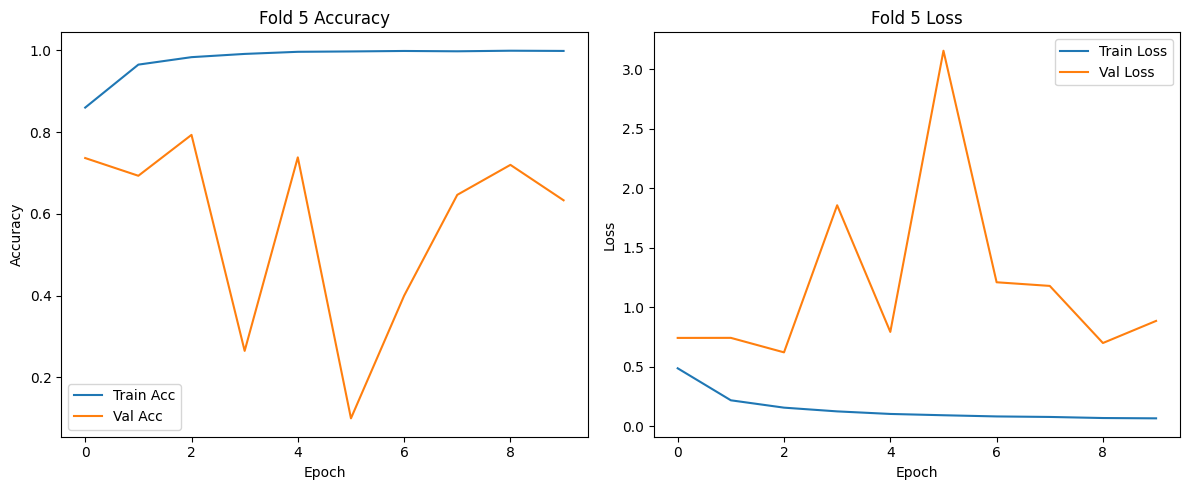

1/1 [==============================] - 1s 774ms/step
Fold 5 Validation Recall: 0.8019
Fold 5 Validation F1 Score: 0.6951


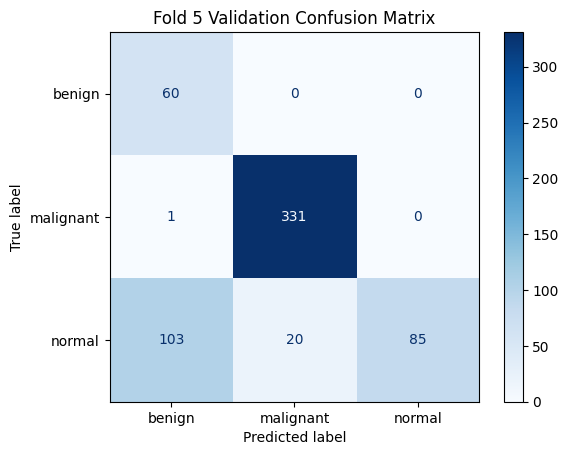

23/23 - 1s - loss: 0.5081 - accuracy: 0.8257 - 830ms/epoch - 36ms/step
Fold 5 Test accuracy: 0.8257 | Test loss: 0.5081
1/1 [==============================] - 0s 30ms/step
Fold 5 Test Recall: 0.7981
Fold 5 Test F1 Score: 0.7026


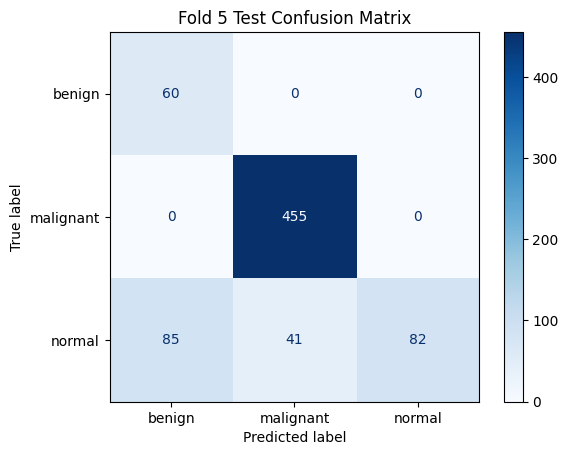

✅ Cross-validation complete using fixed validation and test sets.


In [12]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score
from pathlib import Path
from PIL import Image

# ==== CONFIG ====
base_dir = r"C:\Users\ensi02\hedii\data"
class_names = ['benign', 'malignant', 'normal']
num_classes = len(class_names)
IMG_SIZE = (256, 256)
batch_size = 32
epochs = 30
n_splits = 5

# === Image validation function ===
def is_valid_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # verify image integrity
        return True
    except (IOError, SyntaxError):
        print(f"Invalid image skipped: {filepath}")
        return False

# === Load image paths and labels, skipping invalid images ===
def get_image_paths_and_labels_clean(subset):
    image_paths = []
    labels = []
    for label_index, class_name in enumerate(class_names):
        class_dir = Path(base_dir) / subset / class_name
        for img_path in class_dir.glob('*'):
            if is_valid_image(img_path):
                image_paths.append(str(img_path))
                labels.append(label_index)
    return np.array(image_paths), np.array(labels)

# === Create tf.data.Dataset from file paths and labels ===
def create_dataset(file_paths, labels, shuffle=True):
    def process_path(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, tf.one_hot(label, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# === Load train/valid/test datasets with filtering invalid images ===
train_image_paths, train_labels = get_image_paths_and_labels_clean('train')
valid_image_paths, valid_labels = get_image_paths_and_labels_clean('valid')
test_image_paths, test_labels = get_image_paths_and_labels_clean('test')

# Create fixed validation and test datasets
val_ds_fixed = create_dataset(valid_image_paths, valid_labels, shuffle=False)
test_ds = create_dataset(test_image_paths, test_labels, shuffle=False)

# === KFold on TRAIN only ===
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_no = 1

for train_idx, _ in skf.split(train_image_paths, train_labels):
    print(f"\n=== Fold {fold_no} ===")

    # Split train data only; validation is fixed
    train_paths_fold = train_image_paths[train_idx]
    train_labels_fold = train_labels[train_idx]

    train_ds = create_dataset(train_paths_fold, train_labels_fold, shuffle=True)

    # Load model
    model = tf.keras.models.load_model('xception_model.h5')

    # Unfreeze all layers for fine-tuning
    for layer in model.layers:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=f"logs/finetune_fold_{fold_no}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
    ]

    print("Fine-tuning full model...")
    history = model.fit(
        train_ds,
        validation_data=val_ds_fixed,
        epochs=epochs,
        callbacks=callbacks,
        verbose=2
    )

    model.save(f"fine_tuned_xception_fold{fold_no}.h5")
    print(f"✅ Saved fine-tuned model for fold {fold_no}")

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold_no} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Validation evaluation
    y_true_val, y_pred_val = [], []
    for images, labels in val_ds_fixed:
        preds = model.predict(images)
        y_true_val.extend(tf.argmax(labels, axis=1).numpy())
        y_pred_val.extend(np.argmax(preds, axis=1))

    recall_val = recall_score(y_true_val, y_pred_val, average='macro')
    f1_val = f1_score(y_true_val, y_pred_val, average='macro')
    print(f"Fold {fold_no} Validation Recall: {recall_val:.4f}")
    print(f"Fold {fold_no} Validation F1 Score: {f1_val:.4f}")

    cm_val = confusion_matrix(y_true_val, y_pred_val)
    ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names).plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {fold_no} Validation Confusion Matrix')
    plt.show()

    # Test evaluation
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print(f"Fold {fold_no} Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

    y_true_test, y_pred_test = [], []
    for images, labels in test_ds:
        preds = model.predict(images)
        y_true_test.extend(tf.argmax(labels, axis=1).numpy())
        y_pred_test.extend(np.argmax(preds, axis=1))

    recall_test = recall_score(y_true_test, y_pred_test, average='macro')
    f1_test = f1_score(y_true_test, y_pred_test, average='macro')
    print(f"Fold {fold_no} Test Recall: {recall_test:.4f}")
    print(f"Fold {fold_no} Test F1 Score: {f1_test:.4f}")

    cm_test = confusion_matrix(y_true_test, y_pred_test)
    ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names).plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {fold_no} Test Confusion Matrix')
    plt.show()

    fold_no += 1

print("✅ Cross-validation complete using fixed validation and test sets.")
